# Outlier detection in cifar10 dataset using ``Annoy`` and ``Autogluon``

This exmple shows how to train a model for outlier detection with Cleanlab's ``OutOfDistribution`` class. 

It also shows how to extend outlier detection using feature embeddings to KNN implementations outside of the ``sklearn`` library. The example uses a subclass of ``sklearn.neighbors.NearestNeighbors`` model, ``Annoy`` but any subclass works as long as ``NearestNeighbors`` can return an array of nearest neighbor distances.

## 1. Load packages and set seeds for reprodusability

In [1]:
import os

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams

import warnings

import cleanlab
from cleanlab.outlier import OutOfDistribution
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from annoy import AnnoyIndex

SEED = 42
np.random.seed(SEED)
warnings.filterwarnings("ignore", "Lazy modules are a new feature.*")

/home/ulyana/virtual/multi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_path = "./experiment"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
    print("Directory " , experiment_path ,  " Created ")
else:    
    print("Directory " , experiment_path ,  " already exists")

print(f'Experiment saved in {experiment_path}')

Directory  ./experiment  already exists
Experiment saved in ./experiment


## 2. Download the Cifar10 dataset

In [3]:
# Download CIFAR-10 data for model training
!wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10/cifar10_test.tar.gz'
!tar -xzf cifar10_test.tar.gz

# Here is an alternative command to download the data from the source:
# cifar2png cifar10 ./data/cifar10_test --name-with-batch-index

# Import CIFAR-10 labels and image paths
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_image_paths.npy'
!cd $experiment_path && wget -nc 'https://cleanlab-public.s3.amazonaws.com/Multiannotator/cifar-10h/cifar-10h-worst25-coin20/c10h_test_labels.npy'

File ‘cifar10_test.tar.gz’ already there; not retrieving.

File ‘c10h_image_paths.npy’ already there; not retrieving.

File ‘c10h_test_labels.npy’ already there; not retrieving.



In [24]:
txt_labels = {0: 'airplane', 
              1: 'automobile', 
              2: 'bird',
              3: 'cat', 
              4: 'deer', 
              5: 'dog', 
              6: 'frog', 
              7: 'horse', 
              8:'ship', 
              9:'truck'}

def imshow(img):
    img = cv2.imread(img)[...,::-1]
    return img

def plot_images(image_paths, labels):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = image_paths[i], labels[i]
        ax = plt.subplot(3,5,i+1)
        ax.set_title(txt_labels[int(y)])
        ax.imshow(imshow(X))
    plt.show()

In [5]:
# Load ground labels and image paths
labels = np.load(f'{experiment_path}/c10h_test_labels.npy')
image_paths = np.load(f'{experiment_path}/c10h_image_paths.npy', allow_pickle=True)
path = os.getcwd()
image_paths = np.array([f"{path}/{image_path}" for image_path in image_paths])

# Split CIFAR-10 dataset into train and test
trainx, testx, trainy, testy = train_test_split(image_paths, labels, test_size=0.15, random_state=SEED)

# Manually remove non-animals out of the training dataset
animal_labels = [2,3,4,5,6,7]
animal_idxs = np.where(np.isin(trainy, animal_labels))[0] # find idx of animals
trainx = trainx[animal_idxs]
trainy = trainy[animal_idxs]

# Zip dataset into format accepted by autogluon
trainset = pd.DataFrame(zip(trainx,trainy), columns=["image", "label"])
testset = pd.DataFrame(zip(testx,testy), columns=["image", "label"])

# # Zip dataset into numpy format
# trainx = get_np_array(trainx)
# testy = get_np_array(testx)

# Check the shapes of our training and test sets
print('Trainset length: %s' % (len(trainset)))
print('Testset length: %s' % (len(testset)))

Trainset length: 5099
Testset length: 1500


## 3. Create and train a model

The model we are creating is a `resnet18` using the ``autogluon`` image predictor library. We pass in the train imaged into the model to and save the generated in-distribution intermediate feature embeddings to fit our `OutOfDistribution` estimator on. The model in this example comes from``autogluon.vision`` but outlier detection can be done with any generated in-sample feature embeddings.

In [6]:
from autogluon.vision import ImagePredictor, ImageDataset

model_name = 'resnet18' # or swin_base_patch4_window7_224

# init model
model = ImagePredictor(verbosity=0)

# train model [mini_train vs full train + fix epochs and time_limit]
model.fit(
    train_data=trainset,
    ngpus_per_trial=1,
    hyperparameters={"holdout_frac": 0.2, "model": model_name},
    time_limit=7200,
    random_state=12345,
)

modified configs(<old> != <new>): {
root.train.epochs    200 != 15
root.train.batch_size 32 != 16
root.train.early_stop_patience -1 != 10
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.misc.seed       42 != 134
root.misc.num_workers 4 != 64
root.img_cls.model   resnet101 != resnet18
}
Saved config to /datasets/ulyana/examples/cifar10-outlier-detection/be6fa6e4/.trial_0/config.yaml
Model resnet18 created, param count:                                         11179590
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 168.429177 samples/sec	accuracy=0.147500	lr=0.000100
Epoch[0] Batch [99]	Speed: 838.563110 samples/sec	accuracy=0.158125	lr=0.000100
Epoch[0] Batch [149]	Speed: 833.245144 samples/sec	accuracy=0.182917	lr=0.000100
Epoch[0] Batch [199]	Speed: 841.111615 samples/sec	accuracy=0.202813	lr=0.000100
Epoch[0] Batch [249]	Speed: 848.730689 samples/sec	a

Epoch[12] Batch [99]	Speed: 828.861416 samples/sec	accuracy=0.741250	lr=0.010000
Epoch[12] Batch [149]	Speed: 850.217797 samples/sec	accuracy=0.728750	lr=0.010000
Epoch[12] Batch [199]	Speed: 833.595395 samples/sec	accuracy=0.724375	lr=0.010000
Epoch[12] Batch [249]	Speed: 841.788118 samples/sec	accuracy=0.721500	lr=0.010000
[Epoch 12] training: accuracy=0.723121
[Epoch 12] speed: 792 samples/sec	time cost: 5.757525
[Epoch 12] validation: top1=0.776471 top5=0.994118
Epoch[13] Batch [49]	Speed: 638.723985 samples/sec	accuracy=0.701250	lr=0.010000
Epoch[13] Batch [99]	Speed: 824.256621 samples/sec	accuracy=0.716875	lr=0.010000
Epoch[13] Batch [149]	Speed: 851.521217 samples/sec	accuracy=0.726250	lr=0.010000
Epoch[13] Batch [199]	Speed: 841.257121 samples/sec	accuracy=0.723125	lr=0.010000
Epoch[13] Batch [249]	Speed: 849.349631 samples/sec	accuracy=0.725250	lr=0.010000
[Epoch 13] training: accuracy=0.728802
[Epoch 13] speed: 794 samples/sec	time cost: 5.743075
[Epoch 13] validation: top1=

## 4. Use cleanlab and `feature_embeddings` to find outliers in the dataset

Internally, `cleanlab` uses the `sklearn.neighbors.NearestNeighbor` class (with *cosine* distance) to find the K nearest neighbors, but you can easily pass in another KNN estimator into the `OutOfDistribution` class through the `params` attribute.  `Annoy` a NearestNeighbors estimator that approximates the distances and performs a lot faster than sklearn's implementation, lets use it instead.

In [7]:
# Define our KNN class
class ApproxNearestNeighbors:

    def __init__(self, n_neighbors: int = 5, metric: str = "angular", n_trees: int = 10):
        self.ann_index = None
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.n_trees = n_trees
        
    def fit(self, features: np.array):
        dim = features.shape[1]
        self.ann_index = AnnoyIndex(dim, self.metric)
        for i, x in enumerate(features):
            self.ann_index.add_item(i, x)
        self.ann_index.build(self.n_trees)
        return self
    
    def kneighbors(self, features: np.array):
    
        distances = []
        indices = []
        for x in features:
            idx, dist = self.ann_index.get_nns_by_vector(x, self.n_neighbors, include_distances=True)    
            distances.append(dist)
            indices.append(idx)
        distances = np.array(distances)
        indices = np.array(indices)
        
        return distances, indices

In [8]:
# Generate intermediate feature embeddings and predicted probabilities for train and test sets
train_feature_embeddings = model.predict_feature(trainset['image'].to_list())["image_feature"].values
train_feature_embeddings = np.array(train_feature_embeddings.tolist())
test_feature_embeddings = model.predict_feature(testset['image'].to_list())["image_feature"].values
test_feature_embeddings = np.array(test_feature_embeddings.tolist())

# Fit knn object on train_feature_embeddings
knn = ApproxNearestNeighbors()
knn.fit(train_feature_embeddings)

# Create OutOfDistribution object with knn
OOD = OutOfDistribution(params={"knn": knn})

# Fit and get out-of-distribution features scores for each of our train_data feature embeddings
train_ood_features_scores = OOD.score(features=train_feature_embeddings)

/home/ulyana/u_cleanlab/cleanlab/outlier.py:334: UserWarning: Skipping fit. Object already fit on knn estimator.
  warnings.warn(


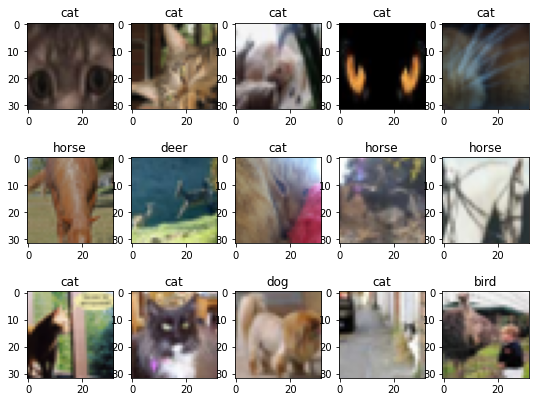

In [25]:
# View images with top 15 out-of-distribution features scores
top_train_ood_features_idxs = train_ood_features_scores.argsort()[:15]
top_train_ood_features = trainset.iloc[top_train_ood_features_idxs]["image"].to_list()
top_train_ood_labels = trainset.iloc[top_train_ood_features_idxs]["label"].to_list()
plot_images(top_train_ood_features, top_train_ood_labels)

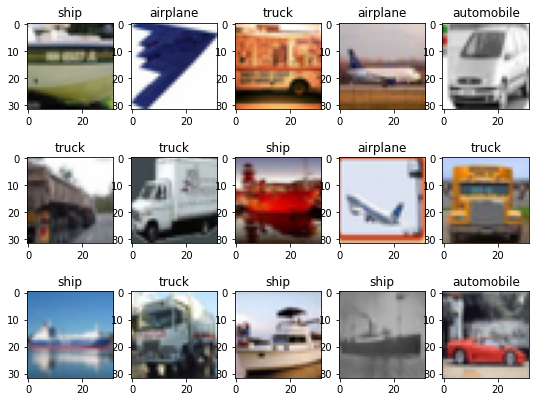

In [26]:
# Fit and get out-of-distribution features scores for each of our test_data feature embeddings
test_ood_features_scores = OOD.score(features=test_feature_embeddings)

# View images with top 15 out-of-distribution features scores
top_test_ood_features_idxs = test_ood_features_scores.argsort()[:15]
top_test_ood_features = testset.iloc[top_test_ood_features_idxs]["image"].to_list()
top_test_ood_labels = testset.iloc[top_test_ood_features_idxs]["label"].to_list()
plot_images(top_test_ood_features, top_test_ood_labels)

To **decide how many of the top scoring examples should be marked as outliers** check out the [Deciding which test examples are outliers](link to outlier tutorial) section in our tutorial.

## 5. Use cleanlab and `pred_probs` to find outliers in the dataset

Cross validation is needed to generate held-out `pred_probs` on the training data. To understand why this is important check out our [Computing Out-of-Sample Predicted Probabilities with Cross-Validation](https://docs.cleanlab.ai/stable/tutorials/pred_probs_cross_val.html) tutorial.

In [50]:
from utils.model_training import train_model, sum_xval_folds

model_results_folder = "./experiment/model_training"
model_type = "resnet18" # You can also try with "swin_base_patch4_window7_224"

# Load model arguments
train_args = {
    "num_cv_folds": 5, # decrease this value if you want code to run faster
    "verbose": 0, 
    "epochs": 50, # decrease this value if you want code to run faster
    "time_limit": 7200, # decrease this value if you want code to run faster
    "random_state": 123,
} 

# Train model
model = train_model(model_type, trainset, model_results_folder, **train_args);
train_pred_probs, labels, images = sum_xval_folds(model_type, model_results_folder, **train_args)
test_pred_probs = np.array(model.predict_proba(testset['image'].to_list()))

Fitting OOD object based on provided pred_probs ...


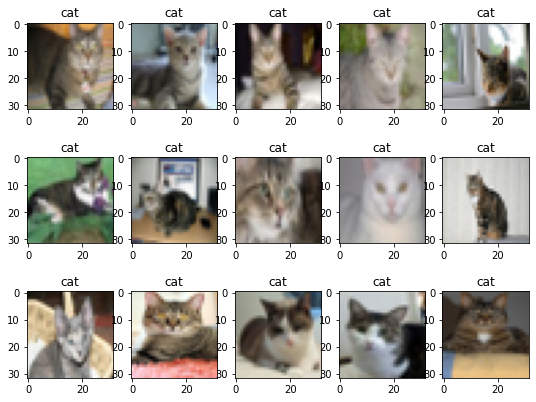

In [51]:
# Zero index train labels
train_labels = trainset['label'].values
train_labels = np.unique(train_labels, return_inverse=True)[1]

# Compute outlier scores for train data
OOD = OutOfDistribution()
train_ood_predictions_scores = OOD.fit_score(pred_probs=train_pred_probs, labels=train_labels)

# View images with top 15 out-of-distribution predictions scores
top_train_idxs = train_ood_predictions_scores.argsort()[:15]
top_train_images = trainset.iloc[top_train_idxs]["image"].to_list()
top_train_labels = trainset.iloc[top_train_idxs]["label"].to_list()
plot_images(top_train_images, top_train_labels)

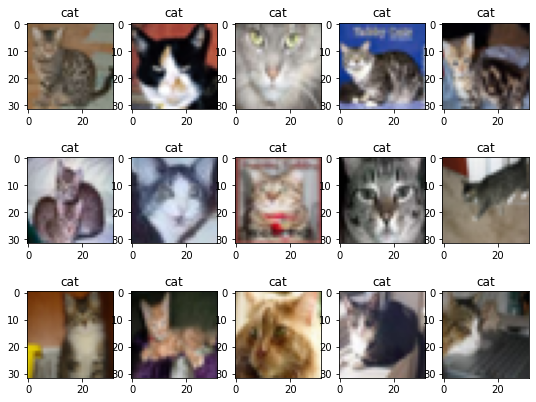

In [52]:
# Compute outlier scores for test data
test_ood_predictions_scores = OOD.score(pred_probs=test_pred_probs)

# View images with top 15 out-of-distribution predictions scores
top_test_idxs = test_ood_predictions_scores.argsort()[:15]
top_test_images = testset.iloc[top_test_idxs]["image"].to_list()
top_test_labels = testset.iloc[top_test_idxs]["label"].to_list()
plot_images(top_test_images, top_test_labels)